In [1]:
%load_ext watermark
%watermark -a Chan -d -v -p numpy,pandas,sklearn,konlpy,tensorflow,matplotlib,imblearn

Using TensorFlow backend.


Chan 2019-08-20 

CPython 3.7.3
IPython 7.6.1

numpy 1.16.4
pandas 0.24.2
sklearn 0.21.2
konlpy 0.5.1
tensorflow 1.14.0
matplotlib 3.1.0
imblearn 0.5.0


In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from konlpy.tag import Okt
import tensorflow as tf
from tensorflow.python.keras.preprocessing import sequence
from tensorflow import keras
from tqdm import tqdm
from collections import Counter
from matplotlib import pyplot as plt
import pickle
from utils import morp_preprocessing

# Load datasets

In [3]:
datasets = pd.read_csv('../../data/train.csv', engine='python', encoding='utf-16')
datasets.head()

,Unnamed: 0,comment,url_id,label
0,0,ㅜㅜ,77,0
1,1,ㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋㅋ,17,0
2,2,헐,52,0
3,3,제시,75,0
4,4,이거인 듯,18,0


In [4]:
datasets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Data columns (total 4 columns):
Unnamed: 0    42000 non-null int64
comment       42000 non-null object
url_id        42000 non-null int64
label         42000 non-null int64
dtypes: int64(3), object(1)
memory usage: 1.3+ MB


# 형태소분석

In [6]:
import re
from konlpy.tag import Okt
okt = Okt()

def prep1(textt = '존ㄴ ㅂ신 병ㅅ 새ㄲ ㅈ나 ㅅ발 ㅁㅊ놈아'):
    pattern2 = re.compile(r'[^ a-zA-Zㄱ-ㅊㅌ-ㅠㅢ-힣]')
    textt = pattern2.sub('',textt)
    temp_okt = okt.pos(textt)
    
    cut_word_h = []
    cut_word_e = []
    temp = []
    
    for a in range(len(temp_okt)):
        if temp_okt[a][1] == 'Alpha':
            cut_word_e.append(temp_okt[a])
        else:
            cut_word_h.append(temp_okt[a])
    
    cut_word_h.extend(cut_word_e)
    temp.extend(cut_word_h)
    
    temp2 = []
    string1 = ''
    k = -1
    one_word = 0

    # 병신, 시발, 씨발, 존나, 느금마, 씨발롬들아, 미친놈아, 새끼, 좆밥
    bad_word = ['ㅂ', 'ㅅ', 'ㅆ', 'ㅈ', 'ㅁㅊ', 'ㄲ', 'ㄴ']
    bad_set_word = ['신', '발', '빨', '나', '놈', '끼', '밥']
    important_class = ['KoreanParticle', 'Noun', 'mixed', 'Verb', 'Alpha']
    not_important_word = ['은', '는', '이', '가', '자']

    for i in range(len(temp)):
        if temp[i][0] in bad_word:
            if i != len(temp) - 1 and temp[i+1][0] in bad_set_word:
                if one_word == 0 and len(temp[i+1][0]) == 1 and temp[i+1][1] == 'Noun' and temp[i+1][0] not in not_important_word:
                    for j in range(i):
                        if j <= k or temp[j][1] not in important_class or (len(temp[j][0]) > 4 and temp[j][1] == 'Verb') or temp[j][0] in not_important_word:
                            continue
                        temp2.append(temp[j])
                    string1 = temp[i][0] + temp[i+1][0]
                    temp2.append((string1, 'mixed'))
                    k = i+1
            else:
                if one_word == 0 and i != 0 and len(temp[i-1][0]) == 1 and  temp[i-1][1] == 'Noun' and temp[i-1][0] not in not_important_word:
                    for j in range(i):
                        if j <= k or temp[j][1] not in important_class or (len(temp[j][0]) > 4 and temp[j][1] == 'Verb') or temp[j][0] in not_important_word:
                            continue
                        temp2.append(temp[j])
                    string1 = temp[i-1][0] + temp[i][0]
                    temp2.pop()
                    temp2.append((string1, 'mixed'))
                    k = i

        if i != len(temp) - 1:
            if temp[i][1] == 'Noun' and temp[i+1][1] == 'Suffix' and temp[i+1][0] not in not_important_word:
                for j in range(i):
                    if j <= k or temp[j][1] not in important_class or (len(temp[j][0]) > 4 and temp[j][1] == 'Verb') or temp[j][0] in not_important_word:
                        continue
                    temp2.append(temp[j])
                string1 = temp[i][0] + temp[i+1][0]
                temp2.append((string1, 'Noun + Suffix'))
                k = i+1
                
        # 형태소분석기가 인식못하는 예외단어
        if i != len(temp) - 1:
            if (temp[i][0] == '운' and temp[i+1][0] == '지') or (temp[i][0] == '노' and temp[i+1][0] == '무현')\
            or (temp[i][0] == '찐' and temp[i+1][0] == '따') or (temp[i][0] == '섹' and temp[i+1][0] == '히')\
            or (temp[i][0] == '새' and temp[i+1][0] == '키') or (temp[i][0] == '새' and temp[i+1][0] == '퀴')\
            or (temp[i][0] == '도' and temp[i+1][0] == '네') or (temp[i][0] == '장애' and temp[i+1][0] == '인색히')\
            or (temp[i][0] == '자' and temp[i+1][0] == '지') or (temp[i][0] == '고' and temp[i+1][0] == '소')\
            or (temp[i][0] == '저능' and temp[i+1][0] == '아') or (temp[i][0] == '색' and temp[i+1][0] == '히')\
            or (temp[i][0] == '쓰래' and temp[i+1][0] == '기') or (temp[i][0] == '애' and temp[i+1][0] == '미')\
            or (temp[i][0] == 'ㅅ' and temp[i+1][0] == 'ㅂ') or (temp[i][0] == 'ㅂ' and temp[i+1][0] == 'ㅅ')\
            or (temp[i][0] == 'ㅈ' and temp[i+1][0] == 'ㄹ') or (temp[i][0] == 'ㅈ' and temp[i+1][0] == 'ㄴ')\
            or (temp[i][0] == 'ㅁ' and temp[i+1][0] == 'ㅊ') or (temp[i][0] == 'ㅅ' and temp[i+1][0] == 'ㄲ')\
            or (temp[i][0] == 'ㅈ' and temp[i+1][0] == 'ㅂ') or (temp[i][0] == '섯' and temp[i+1][0] == '네')\
            or (temp[i][0] == '섰' and temp[i+1][0] == '네') or (temp[i][0] == '섯' and temp[i+1][0] == '다')\
            or (temp[i][0] == '섰' and temp[i+1][0] == '다'):
                for j in range(i):
                    if j <= k or temp[j][1] not in important_class or (len(temp[j][0]) > 4 and temp[j][1] == 'Verb') or temp[j][0] in not_important_word:
                        continue
                    temp2.append(temp[j])
                string1 = temp[i][0] + temp[i+1][0]
                temp2.append((string1, 'Except'))
                k = i+1
        
    else:
        for j in range(len(temp)):
            if j <= k or temp[j][1] not in important_class or (len(temp[j][0]) > 4 and temp[j][1] == 'Verb') or temp[j][0] in not_important_word:
                continue
            temp2.append(temp[j])

    result = []
    
    for b in range(len(temp2)):
        result.append(temp2[b][0])
    
    return result

C:\Users\skarn\Anaconda3\envs\DataAnalysis\lib\site-packages\jpype\_core.py:210: UserWarning: 
-------------------------------------------------------------------------------
Deprecated: convertStrings was not specified when starting the JVM. The default
behavior in JPype will be False starting in JPype 0.8. The recommended setting
for new code is convertStrings=False.  The legacy value of True was assumed for
this session. If you are a user of an application that reported this warning,
please file a ticket with the developer.
-------------------------------------------------------------------------------

  """)


In [7]:
chat = list()
for _ in tqdm(datasets.comment.values):
    chat.append(prep1(_))
chat[:5]

100%|███████████████████████████████████████████████████████████████████████████| 42000/42000 [00:55<00:00, 751.75it/s]


[['ㅜㅜ'], [], ['헐'], ['제시'], ['거인', '듯']]

In [8]:
vocab_size = 30000

pad_id = 0
oov_id = 1
index_offset = 1

def make_vocab(sentences):
    word_counter = Counter()

    for sent in sentences:
        word_counter.update(sent)

    most_common = word_counter.most_common()
    print("고빈도 단어:")
    for k, v in most_common[:10]:
        print(k, ": ", v)

    vocab = {
    '<PAD>': pad_id,
    '<OOV>': oov_id
    }
    for i, (word, cnt) in enumerate(most_common, start=index_offset+1):
        vocab[word] = i
        if len(vocab) >= vocab_size:
            break

    return vocab

word_index = make_vocab(chat)
word_inverted_index = {v:k for k, v in word_index.items()}

print("\n단어 사전:")
for i in range(0, 10):
    print(i, word_inverted_index[i])

print("\n단어 사전 크기: ", len(word_index))

# # vocab save
# with open('./vocab/vocab_index.pickle', 'wb') as f:
#     pickle.dump(word_index, f, pickle.HIGHEST_PROTOCOL)
# with open('./vocab/vocab_inverted_index.pickle', 'wb') as f:
#     pickle.dump(word_inverted_index, f, pickle.HIGHEST_PROTOCOL)

고빈도 단어:
와 :  645
ㄷㄷ :  621
진짜 :  494
거 :  468
채팅 :  468
형 :  450
중 :  428
창 :  408
싹둑 :  398
관리 :  387

단어 사전:
0 <PAD>
1 <OOV>
2 와
3 ㄷㄷ
4 진짜
5 거
6 채팅
7 형
8 중
9 창

단어 사전 크기:  20185


In [9]:
def index_to_text(indexes):
    return ' '.join([word_inverted_index[i] for i in indexes])

def text_to_index(tokens):
    indexes = []
    for tok in tokens:
        if tok in word_index:
            indexes.append(word_index[tok])
        else:
            indexes.append(oov_id)

    return indexes

print("원본: ", chat[0])
ids = text_to_index(chat[0])
print("문자 -> 숫자: ", ids)
print("숫자 -> 문자: ", index_to_text(ids))

원본:  ['ㅜㅜ']
문자 -> 숫자:  [124]
숫자 -> 문자:  ㅜㅜ


In [10]:
x_variable = [text_to_index(_) for _ in chat]

sentence_size = 10
x_padded = sequence.pad_sequences(x_variable,
                                 maxlen=sentence_size,
                                 truncating='post',
                                 padding='post',
                                 value=pad_id)

In [11]:
def plot_loss(history):
    plt.figure(figsize=(6,5))
    val = plt.plot(history.epoch, history.history['val_loss'],
                 '--', label='Test')
    plt.plot(history.epoch, history.history['loss'], color=val[0].get_color(),
           label='Train')

    plt.xlabel('Epochs')
    plt.ylabel("Loss")
    plt.legend()

    plt.xlim([0,max(history.epoch)])

In [12]:
import warnings
warnings.filterwarnings(action='once')


# 데이터 클래스 불균형 문제 해결하자

In [13]:
X_train, X_test, y_train, y_test = train_test_split(x_padded, datasets.label)

In [14]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler,SMOTE

In [15]:
up_X, up_y = RandomOverSampler().fit_resample(X_train, y_train)

# 총 데이터 수 , 1 레이블 데이터 수
len(up_y), up_y.sum()

(59822, 29911)

In [16]:
model_up = keras.Sequential([
    keras.layers.Embedding(30000, 10),
    keras.layers.Conv1D(64, 4, padding="same", activation=tf.nn.relu),
    keras.layers.Dropout(0.5),
    keras.layers.Conv1D(32, 2, padding="same", activation=tf.nn.relu),
    keras.layers.Dropout(0.5),
    keras.layers.Conv1D(32, 2, padding="same", activation=tf.nn.relu),
    keras.layers.Dropout(0.5),
    keras.layers.Conv1D(32, 2, padding="same", activation=tf.nn.relu),
    keras.layers.Dropout(0.5),
    keras.layers.Conv1D(32, 2, padding="same", activation=tf.nn.relu),
    keras.layers.Dropout(0.5),
    keras.layers.Conv1D(32, 2, padding="same", activation=tf.nn.relu),
    keras.layers.Dropout(0.5),
    keras.layers.Conv1D(32, 2, padding="same", activation=tf.nn.relu),
    keras.layers.GlobalMaxPool1D(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2, activation=tf.nn.sigmoid)
])

W0820 20:01:29.798974 11528 deprecation.py:506] From C:\Users\skarn\Anaconda3\envs\DataAnalysis\lib\site-packages\tensorflow\python\keras\initializers.py:119: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0820 20:01:29.801961 11528 deprecation.py:506] From C:\Users\skarn\Anaconda3\envs\DataAnalysis\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
C:\Users\skarn\Anaconda3\envs\DataAnalysis\lib\site-packages\tensorflow\python\ops\nn_ops.py:61: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from

W0820 20:01:38.236131 11528 deprecation.py:323] From C:\Users\skarn\Anaconda3\envs\DataAnalysis\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 59822 samples, validate on 10500 samples
Epoch 1/5


11776/59822 [====>.........................] - ETA: 1:05:49 - loss: 0.6937 - recall: 0.281 - ETA: 22:51 - loss: 0.6950 - recall: 0.3229  - ETA: 17:31 - loss: 0.6947 - recall: 0.273 - ETA: 12:00 - loss: 0.6940 - recall: 0.302 - ETA: 9:15 - loss: 0.6937 - recall: 0.335 - ETA: 7:36 - loss: 0.6940 - recall: 0.34 - ETA: 6:30 - loss: 0.6938 - recall: 0.35 - ETA: 5:43 - loss: 0.6937 - recall: 0.37 - ETA: 5:07 - loss: 0.6934 - recall: 0.37 - ETA: 4:38 - loss: 0.6934 - recall: 0.38 - ETA: 4:16 - loss: 0.6935 - recall: 0.38 - ETA: 3:57 - loss: 0.6938 - recall: 0.38 - ETA: 3:42 - loss: 0.6938 - recall: 0.38 - ETA: 3:29 - loss: 0.6937 - recall: 0.40 - ETA: 3:18 - loss: 0.6936 - recall: 0.40 - ETA: 3:03 - loss: 0.6935 - recall: 0.40 - ETA: 2:55 - loss: 0.6935 - recall: 0.40 - ETA: 2:52 - loss: 0.6936 - recall: 0.40 - ETA: 2:45 - loss: 0.6935 - recall: 0.41 - ETA: 2:40 - loss: 0.6935 - recall: 0.41 - ETA: 2:35 - loss: 0.6936 - recall: 0.40 - ETA: 2:31 - loss: 0.6937 - recall: 0.40 - ETA: 2:26 - loss

23264/59822 [==========>...................] - ETA: 58s - loss: 0.6934 - recall: 0.502 - ETA: 58s - loss: 0.6935 - recall: 0.501 - ETA: 58s - loss: 0.6935 - recall: 0.501 - ETA: 58s - loss: 0.6935 - recall: 0.501 - ETA: 58s - loss: 0.6934 - recall: 0.502 - ETA: 58s - loss: 0.6935 - recall: 0.502 - ETA: 58s - loss: 0.6935 - recall: 0.502 - ETA: 58s - loss: 0.6935 - recall: 0.502 - ETA: 58s - loss: 0.6935 - recall: 0.502 - ETA: 57s - loss: 0.6935 - recall: 0.502 - ETA: 57s - loss: 0.6935 - recall: 0.502 - ETA: 57s - loss: 0.6935 - recall: 0.502 - ETA: 57s - loss: 0.6935 - recall: 0.502 - ETA: 57s - loss: 0.6935 - recall: 0.502 - ETA: 57s - loss: 0.6935 - recall: 0.502 - ETA: 57s - loss: 0.6935 - recall: 0.503 - ETA: 57s - loss: 0.6935 - recall: 0.503 - ETA: 57s - loss: 0.6935 - recall: 0.503 - ETA: 57s - loss: 0.6935 - recall: 0.503 - ETA: 56s - loss: 0.6935 - recall: 0.504 - ETA: 56s - loss: 0.6935 - recall: 0.504 - ETA: 56s - loss: 0.6935 - recall: 0.504 - ETA: 56s - loss: 0.6935 - rec

35360/59822 [================>.............] - ETA: 43s - loss: 0.6934 - recall: 0.504 - ETA: 43s - loss: 0.6934 - recall: 0.504 - ETA: 42s - loss: 0.6934 - recall: 0.504 - ETA: 42s - loss: 0.6934 - recall: 0.504 - ETA: 42s - loss: 0.6934 - recall: 0.504 - ETA: 42s - loss: 0.6934 - recall: 0.503 - ETA: 42s - loss: 0.6934 - recall: 0.504 - ETA: 42s - loss: 0.6934 - recall: 0.504 - ETA: 42s - loss: 0.6934 - recall: 0.504 - ETA: 42s - loss: 0.6934 - recall: 0.504 - ETA: 42s - loss: 0.6934 - recall: 0.504 - ETA: 42s - loss: 0.6934 - recall: 0.504 - ETA: 42s - loss: 0.6934 - recall: 0.504 - ETA: 42s - loss: 0.6934 - recall: 0.504 - ETA: 41s - loss: 0.6934 - recall: 0.504 - ETA: 41s - loss: 0.6934 - recall: 0.504 - ETA: 41s - loss: 0.6934 - recall: 0.504 - ETA: 41s - loss: 0.6934 - recall: 0.504 - ETA: 41s - loss: 0.6934 - recall: 0.503 - ETA: 41s - loss: 0.6934 - recall: 0.503 - ETA: 41s - loss: 0.6934 - recall: 0.503 - ETA: 41s - loss: 0.6934 - recall: 0.503 - ETA: 41s - loss: 0.6934 - rec

47648/59822 [======================>.......] - ETA: 27s - loss: 0.6933 - recall: 0.504 - ETA: 27s - loss: 0.6933 - recall: 0.504 - ETA: 27s - loss: 0.6933 - recall: 0.504 - ETA: 27s - loss: 0.6933 - recall: 0.504 - ETA: 27s - loss: 0.6933 - recall: 0.504 - ETA: 27s - loss: 0.6933 - recall: 0.504 - ETA: 26s - loss: 0.6933 - recall: 0.503 - ETA: 26s - loss: 0.6933 - recall: 0.503 - ETA: 26s - loss: 0.6933 - recall: 0.503 - ETA: 26s - loss: 0.6933 - recall: 0.503 - ETA: 26s - loss: 0.6933 - recall: 0.503 - ETA: 26s - loss: 0.6933 - recall: 0.503 - ETA: 26s - loss: 0.6933 - recall: 0.503 - ETA: 26s - loss: 0.6933 - recall: 0.503 - ETA: 26s - loss: 0.6933 - recall: 0.503 - ETA: 26s - loss: 0.6933 - recall: 0.503 - ETA: 26s - loss: 0.6933 - recall: 0.503 - ETA: 26s - loss: 0.6933 - recall: 0.503 - ETA: 25s - loss: 0.6933 - recall: 0.503 - ETA: 25s - loss: 0.6933 - recall: 0.503 - ETA: 25s - loss: 0.6933 - recall: 0.503 - ETA: 25s - loss: 0.6933 - recall: 0.503 - ETA: 25s - loss: 0.6933 - rec

59822/59822 [==============================] - ETA: 13s - loss: 0.6933 - recall: 0.505 - ETA: 13s - loss: 0.6933 - recall: 0.504 - ETA: 13s - loss: 0.6933 - recall: 0.504 - ETA: 12s - loss: 0.6933 - recall: 0.504 - ETA: 12s - loss: 0.6933 - recall: 0.504 - ETA: 12s - loss: 0.6933 - recall: 0.504 - ETA: 12s - loss: 0.6933 - recall: 0.504 - ETA: 12s - loss: 0.6933 - recall: 0.504 - ETA: 12s - loss: 0.6933 - recall: 0.504 - ETA: 12s - loss: 0.6933 - recall: 0.504 - ETA: 12s - loss: 0.6933 - recall: 0.503 - ETA: 12s - loss: 0.6933 - recall: 0.503 - ETA: 12s - loss: 0.6933 - recall: 0.503 - ETA: 12s - loss: 0.6933 - recall: 0.503 - ETA: 12s - loss: 0.6933 - recall: 0.503 - ETA: 12s - loss: 0.6933 - recall: 0.502 - ETA: 12s - loss: 0.6933 - recall: 0.502 - ETA: 12s - loss: 0.6933 - recall: 0.502 - ETA: 11s - loss: 0.6933 - recall: 0.502 - ETA: 11s - loss: 0.6933 - recall: 0.502 - ETA: 11s - loss: 0.6933 - recall: 0.502 - ETA: 11s - loss: 0.6933 - recall: 0.502 - ETA: 11s - loss: 0.6933 - rec

12352/59822 [=====>........................] - ETA: 52s - loss: 0.6972 - recall: 0.468 - ETA: 59s - loss: 0.6745 - recall: 0.510 - ETA: 1:07 - loss: 0.7001 - recall: 0.43 - ETA: 58s - loss: 0.6958 - recall: 0.4766 - ETA: 59s - loss: 0.6942 - recall: 0.515 - ETA: 58s - loss: 0.6917 - recall: 0.546 - ETA: 58s - loss: 0.6881 - recall: 0.546 - ETA: 58s - loss: 0.6862 - recall: 0.556 - ETA: 1:02 - loss: 0.6865 - recall: 0.55 - ETA: 1:01 - loss: 0.6832 - recall: 0.56 - ETA: 1:02 - loss: 0.6810 - recall: 0.56 - ETA: 1:02 - loss: 0.6843 - recall: 0.56 - ETA: 1:03 - loss: 0.6818 - recall: 0.57 - ETA: 1:06 - loss: 0.6826 - recall: 0.56 - ETA: 1:05 - loss: 0.6779 - recall: 0.56 - ETA: 1:07 - loss: 0.6748 - recall: 0.57 - ETA: 1:05 - loss: 0.6782 - recall: 0.57 - ETA: 1:07 - loss: 0.6757 - recall: 0.57 - ETA: 1:06 - loss: 0.6737 - recall: 0.57 - ETA: 1:05 - loss: 0.6724 - recall: 0.58 - ETA: 1:05 - loss: 0.6696 - recall: 0.58 - ETA: 1:04 - loss: 0.6675 - recall: 0.59 - ETA: 1:04 - loss: 0.6655 - r

24384/59822 [===========>..................] - ETA: 46s - loss: 0.5895 - recall: 0.712 - ETA: 46s - loss: 0.5893 - recall: 0.712 - ETA: 46s - loss: 0.5888 - recall: 0.712 - ETA: 46s - loss: 0.5887 - recall: 0.712 - ETA: 46s - loss: 0.5881 - recall: 0.712 - ETA: 46s - loss: 0.5877 - recall: 0.713 - ETA: 46s - loss: 0.5875 - recall: 0.713 - ETA: 46s - loss: 0.5873 - recall: 0.713 - ETA: 46s - loss: 0.5865 - recall: 0.713 - ETA: 46s - loss: 0.5870 - recall: 0.713 - ETA: 46s - loss: 0.5866 - recall: 0.714 - ETA: 46s - loss: 0.5865 - recall: 0.714 - ETA: 46s - loss: 0.5865 - recall: 0.714 - ETA: 46s - loss: 0.5867 - recall: 0.714 - ETA: 46s - loss: 0.5862 - recall: 0.714 - ETA: 46s - loss: 0.5861 - recall: 0.714 - ETA: 46s - loss: 0.5859 - recall: 0.714 - ETA: 46s - loss: 0.5856 - recall: 0.714 - ETA: 46s - loss: 0.5857 - recall: 0.714 - ETA: 46s - loss: 0.5863 - recall: 0.714 - ETA: 46s - loss: 0.5862 - recall: 0.714 - ETA: 46s - loss: 0.5860 - recall: 0.714 - ETA: 46s - loss: 0.5860 - rec

36672/59822 [=================>............] - ETA: 35s - loss: 0.5593 - recall: 0.736 - ETA: 35s - loss: 0.5590 - recall: 0.737 - ETA: 35s - loss: 0.5586 - recall: 0.737 - ETA: 35s - loss: 0.5585 - recall: 0.737 - ETA: 35s - loss: 0.5582 - recall: 0.737 - ETA: 35s - loss: 0.5582 - recall: 0.737 - ETA: 35s - loss: 0.5579 - recall: 0.737 - ETA: 34s - loss: 0.5577 - recall: 0.738 - ETA: 34s - loss: 0.5573 - recall: 0.738 - ETA: 34s - loss: 0.5570 - recall: 0.738 - ETA: 34s - loss: 0.5567 - recall: 0.738 - ETA: 34s - loss: 0.5563 - recall: 0.738 - ETA: 34s - loss: 0.5561 - recall: 0.739 - ETA: 34s - loss: 0.5558 - recall: 0.739 - ETA: 34s - loss: 0.5556 - recall: 0.739 - ETA: 34s - loss: 0.5554 - recall: 0.739 - ETA: 34s - loss: 0.5555 - recall: 0.739 - ETA: 34s - loss: 0.5551 - recall: 0.739 - ETA: 34s - loss: 0.5547 - recall: 0.739 - ETA: 34s - loss: 0.5553 - recall: 0.740 - ETA: 34s - loss: 0.5550 - recall: 0.740 - ETA: 33s - loss: 0.5556 - recall: 0.740 - ETA: 33s - loss: 0.5555 - rec

48736/59822 [=======================>......] - ETA: 22s - loss: 0.5284 - recall: 0.759 - ETA: 22s - loss: 0.5282 - recall: 0.759 - ETA: 22s - loss: 0.5280 - recall: 0.759 - ETA: 22s - loss: 0.5280 - recall: 0.759 - ETA: 22s - loss: 0.5279 - recall: 0.759 - ETA: 22s - loss: 0.5277 - recall: 0.759 - ETA: 22s - loss: 0.5275 - recall: 0.760 - ETA: 22s - loss: 0.5275 - recall: 0.760 - ETA: 22s - loss: 0.5274 - recall: 0.760 - ETA: 22s - loss: 0.5272 - recall: 0.760 - ETA: 22s - loss: 0.5271 - recall: 0.760 - ETA: 22s - loss: 0.5270 - recall: 0.760 - ETA: 22s - loss: 0.5268 - recall: 0.760 - ETA: 22s - loss: 0.5266 - recall: 0.761 - ETA: 22s - loss: 0.5265 - recall: 0.761 - ETA: 21s - loss: 0.5265 - recall: 0.761 - ETA: 21s - loss: 0.5262 - recall: 0.761 - ETA: 21s - loss: 0.5261 - recall: 0.761 - ETA: 21s - loss: 0.5258 - recall: 0.761 - ETA: 21s - loss: 0.5257 - recall: 0.761 - ETA: 21s - loss: 0.5254 - recall: 0.761 - ETA: 21s - loss: 0.5252 - recall: 0.761 - ETA: 21s - loss: 0.5254 - rec

59822/59822 [==============================] - ETA: 11s - loss: 0.5116 - recall: 0.770 - ETA: 11s - loss: 0.5117 - recall: 0.769 - ETA: 11s - loss: 0.5120 - recall: 0.769 - ETA: 10s - loss: 0.5120 - recall: 0.769 - ETA: 10s - loss: 0.5121 - recall: 0.769 - ETA: 10s - loss: 0.5119 - recall: 0.770 - ETA: 10s - loss: 0.5118 - recall: 0.770 - ETA: 10s - loss: 0.5117 - recall: 0.770 - ETA: 10s - loss: 0.5116 - recall: 0.770 - ETA: 10s - loss: 0.5114 - recall: 0.770 - ETA: 10s - loss: 0.5113 - recall: 0.770 - ETA: 10s - loss: 0.5112 - recall: 0.770 - ETA: 10s - loss: 0.5110 - recall: 0.770 - ETA: 10s - loss: 0.5108 - recall: 0.770 - ETA: 10s - loss: 0.5108 - recall: 0.770 - ETA: 10s - loss: 0.5107 - recall: 0.770 - ETA: 10s - loss: 0.5106 - recall: 0.771 - ETA: 10s - loss: 0.5105 - recall: 0.771 - ETA: 9s - loss: 0.5104 - recall: 0.771 - ETA: 9s - loss: 0.5102 - recall: 0.77 - ETA: 9s - loss: 0.5102 - recall: 0.77 - ETA: 9s - loss: 0.5101 - recall: 0.77 - ETA: 9s - loss: 0.5100 - recall: 0.7

12064/59822 [=====>........................] - ETA: 57s - loss: 0.4678 - recall: 0.781 - ETA: 1:01 - loss: 0.4668 - recall: 0.75 - ETA: 1:02 - loss: 0.4382 - recall: 0.78 - ETA: 1:03 - loss: 0.4500 - recall: 0.77 - ETA: 1:02 - loss: 0.4515 - recall: 0.77 - ETA: 1:02 - loss: 0.4474 - recall: 0.77 - ETA: 1:02 - loss: 0.4297 - recall: 0.79 - ETA: 1:03 - loss: 0.4409 - recall: 0.78 - ETA: 1:02 - loss: 0.4288 - recall: 0.79 - ETA: 1:01 - loss: 0.4222 - recall: 0.80 - ETA: 1:00 - loss: 0.4248 - recall: 0.80 - ETA: 1:00 - loss: 0.4191 - recall: 0.80 - ETA: 1:00 - loss: 0.4151 - recall: 0.80 - ETA: 1:01 - loss: 0.4139 - recall: 0.80 - ETA: 1:01 - loss: 0.4122 - recall: 0.81 - ETA: 1:00 - loss: 0.4128 - recall: 0.81 - ETA: 1:00 - loss: 0.4195 - recall: 0.81 - ETA: 59s - loss: 0.4193 - recall: 0.8089 - ETA: 1:00 - loss: 0.4165 - recall: 0.81 - ETA: 1:00 - loss: 0.4184 - recall: 0.80 - ETA: 1:00 - loss: 0.4155 - recall: 0.81 - ETA: 59s - loss: 0.4158 - recall: 0.8110 - ETA: 59s - loss: 0.4143 - r

24192/59822 [===========>..................] - ETA: 51s - loss: 0.4124 - recall: 0.827 - ETA: 51s - loss: 0.4124 - recall: 0.827 - ETA: 51s - loss: 0.4121 - recall: 0.828 - ETA: 51s - loss: 0.4120 - recall: 0.828 - ETA: 51s - loss: 0.4123 - recall: 0.827 - ETA: 51s - loss: 0.4123 - recall: 0.827 - ETA: 51s - loss: 0.4118 - recall: 0.828 - ETA: 50s - loss: 0.4118 - recall: 0.828 - ETA: 50s - loss: 0.4117 - recall: 0.828 - ETA: 50s - loss: 0.4117 - recall: 0.828 - ETA: 50s - loss: 0.4114 - recall: 0.828 - ETA: 50s - loss: 0.4115 - recall: 0.828 - ETA: 50s - loss: 0.4122 - recall: 0.827 - ETA: 50s - loss: 0.4118 - recall: 0.827 - ETA: 50s - loss: 0.4114 - recall: 0.828 - ETA: 50s - loss: 0.4112 - recall: 0.828 - ETA: 50s - loss: 0.4116 - recall: 0.828 - ETA: 50s - loss: 0.4109 - recall: 0.828 - ETA: 50s - loss: 0.4111 - recall: 0.828 - ETA: 50s - loss: 0.4111 - recall: 0.828 - ETA: 50s - loss: 0.4110 - recall: 0.828 - ETA: 50s - loss: 0.4112 - recall: 0.828 - ETA: 49s - loss: 0.4110 - rec

36480/59822 [=================>............] - ETA: 37s - loss: 0.4131 - recall: 0.826 - ETA: 36s - loss: 0.4131 - recall: 0.826 - ETA: 36s - loss: 0.4130 - recall: 0.826 - ETA: 36s - loss: 0.4128 - recall: 0.826 - ETA: 36s - loss: 0.4130 - recall: 0.826 - ETA: 36s - loss: 0.4130 - recall: 0.826 - ETA: 36s - loss: 0.4128 - recall: 0.826 - ETA: 36s - loss: 0.4126 - recall: 0.826 - ETA: 36s - loss: 0.4122 - recall: 0.826 - ETA: 36s - loss: 0.4122 - recall: 0.826 - ETA: 36s - loss: 0.4120 - recall: 0.826 - ETA: 36s - loss: 0.4123 - recall: 0.826 - ETA: 36s - loss: 0.4121 - recall: 0.826 - ETA: 36s - loss: 0.4121 - recall: 0.826 - ETA: 36s - loss: 0.4119 - recall: 0.826 - ETA: 36s - loss: 0.4115 - recall: 0.827 - ETA: 35s - loss: 0.4112 - recall: 0.827 - ETA: 35s - loss: 0.4111 - recall: 0.827 - ETA: 35s - loss: 0.4109 - recall: 0.827 - ETA: 35s - loss: 0.4114 - recall: 0.827 - ETA: 35s - loss: 0.4115 - recall: 0.827 - ETA: 35s - loss: 0.4115 - recall: 0.827 - ETA: 35s - loss: 0.4116 - rec

48320/59822 [=======================>......] - ETA: 23s - loss: 0.4129 - recall: 0.828 - ETA: 23s - loss: 0.4130 - recall: 0.828 - ETA: 23s - loss: 0.4128 - recall: 0.828 - ETA: 23s - loss: 0.4129 - recall: 0.828 - ETA: 23s - loss: 0.4129 - recall: 0.828 - ETA: 23s - loss: 0.4127 - recall: 0.828 - ETA: 23s - loss: 0.4127 - recall: 0.828 - ETA: 23s - loss: 0.4127 - recall: 0.828 - ETA: 23s - loss: 0.4126 - recall: 0.828 - ETA: 23s - loss: 0.4130 - recall: 0.828 - ETA: 23s - loss: 0.4130 - recall: 0.828 - ETA: 22s - loss: 0.4128 - recall: 0.828 - ETA: 22s - loss: 0.4128 - recall: 0.828 - ETA: 22s - loss: 0.4127 - recall: 0.828 - ETA: 22s - loss: 0.4127 - recall: 0.828 - ETA: 22s - loss: 0.4125 - recall: 0.829 - ETA: 22s - loss: 0.4126 - recall: 0.828 - ETA: 22s - loss: 0.4126 - recall: 0.829 - ETA: 22s - loss: 0.4126 - recall: 0.828 - ETA: 22s - loss: 0.4127 - recall: 0.828 - ETA: 22s - loss: 0.4127 - recall: 0.828 - ETA: 22s - loss: 0.4126 - recall: 0.828 - ETA: 22s - loss: 0.4128 - rec

59822/59822 [==============================] - ETA: 11s - loss: 0.4101 - recall: 0.829 - ETA: 11s - loss: 0.4101 - recall: 0.829 - ETA: 11s - loss: 0.4100 - recall: 0.829 - ETA: 11s - loss: 0.4099 - recall: 0.830 - ETA: 11s - loss: 0.4100 - recall: 0.830 - ETA: 11s - loss: 0.4101 - recall: 0.829 - ETA: 11s - loss: 0.4104 - recall: 0.829 - ETA: 11s - loss: 0.4104 - recall: 0.829 - ETA: 11s - loss: 0.4105 - recall: 0.829 - ETA: 11s - loss: 0.4105 - recall: 0.829 - ETA: 11s - loss: 0.4105 - recall: 0.829 - ETA: 11s - loss: 0.4105 - recall: 0.829 - ETA: 11s - loss: 0.4107 - recall: 0.829 - ETA: 10s - loss: 0.4108 - recall: 0.829 - ETA: 10s - loss: 0.4109 - recall: 0.829 - ETA: 10s - loss: 0.4109 - recall: 0.829 - ETA: 10s - loss: 0.4109 - recall: 0.829 - ETA: 10s - loss: 0.4109 - recall: 0.829 - ETA: 10s - loss: 0.4109 - recall: 0.829 - ETA: 10s - loss: 0.4109 - recall: 0.829 - ETA: 10s - loss: 0.4108 - recall: 0.829 - ETA: 10s - loss: 0.4108 - recall: 0.829 - ETA: 10s - loss: 0.4107 - rec

11648/59822 [====>.........................] - ETA: 1:01 - loss: 0.3028 - recall: 0.90 - ETA: 1:02 - loss: 0.3238 - recall: 0.88 - ETA: 59s - loss: 0.3424 - recall: 0.8750 - ETA: 58s - loss: 0.3548 - recall: 0.861 - ETA: 58s - loss: 0.3518 - recall: 0.861 - ETA: 58s - loss: 0.3359 - recall: 0.875 - ETA: 58s - loss: 0.3349 - recall: 0.877 - ETA: 57s - loss: 0.3398 - recall: 0.875 - ETA: 56s - loss: 0.3418 - recall: 0.869 - ETA: 57s - loss: 0.3503 - recall: 0.861 - ETA: 56s - loss: 0.3464 - recall: 0.863 - ETA: 57s - loss: 0.3551 - recall: 0.857 - ETA: 57s - loss: 0.3620 - recall: 0.856 - ETA: 58s - loss: 0.3603 - recall: 0.858 - ETA: 58s - loss: 0.3631 - recall: 0.854 - ETA: 59s - loss: 0.3678 - recall: 0.850 - ETA: 59s - loss: 0.3676 - recall: 0.849 - ETA: 1:00 - loss: 0.3675 - recall: 0.84 - ETA: 59s - loss: 0.3690 - recall: 0.8481 - ETA: 1:00 - loss: 0.3662 - recall: 0.84 - ETA: 59s - loss: 0.3622 - recall: 0.8523 - ETA: 59s - loss: 0.3676 - recall: 0.847 - ETA: 1:00 - loss: 0.3621 -

24032/59822 [===========>..................] - ETA: 52s - loss: 0.3955 - recall: 0.832 - ETA: 52s - loss: 0.3955 - recall: 0.832 - ETA: 52s - loss: 0.3952 - recall: 0.832 - ETA: 51s - loss: 0.3950 - recall: 0.832 - ETA: 51s - loss: 0.3958 - recall: 0.832 - ETA: 51s - loss: 0.3958 - recall: 0.832 - ETA: 51s - loss: 0.3963 - recall: 0.832 - ETA: 51s - loss: 0.3959 - recall: 0.832 - ETA: 51s - loss: 0.3960 - recall: 0.832 - ETA: 51s - loss: 0.3965 - recall: 0.831 - ETA: 51s - loss: 0.3965 - recall: 0.831 - ETA: 51s - loss: 0.3967 - recall: 0.831 - ETA: 50s - loss: 0.3965 - recall: 0.831 - ETA: 50s - loss: 0.3970 - recall: 0.831 - ETA: 50s - loss: 0.3974 - recall: 0.830 - ETA: 50s - loss: 0.3975 - recall: 0.830 - ETA: 50s - loss: 0.3974 - recall: 0.830 - ETA: 50s - loss: 0.3976 - recall: 0.830 - ETA: 50s - loss: 0.3976 - recall: 0.831 - ETA: 50s - loss: 0.3974 - recall: 0.831 - ETA: 50s - loss: 0.3968 - recall: 0.831 - ETA: 50s - loss: 0.3971 - recall: 0.831 - ETA: 50s - loss: 0.3967 - rec

36288/59822 [=================>............] - ETA: 36s - loss: 0.3947 - recall: 0.834 - ETA: 36s - loss: 0.3948 - recall: 0.834 - ETA: 36s - loss: 0.3948 - recall: 0.834 - ETA: 36s - loss: 0.3946 - recall: 0.834 - ETA: 36s - loss: 0.3946 - recall: 0.834 - ETA: 36s - loss: 0.3945 - recall: 0.834 - ETA: 36s - loss: 0.3945 - recall: 0.834 - ETA: 36s - loss: 0.3946 - recall: 0.834 - ETA: 36s - loss: 0.3945 - recall: 0.834 - ETA: 36s - loss: 0.3945 - recall: 0.834 - ETA: 35s - loss: 0.3945 - recall: 0.834 - ETA: 35s - loss: 0.3946 - recall: 0.834 - ETA: 35s - loss: 0.3946 - recall: 0.834 - ETA: 35s - loss: 0.3947 - recall: 0.834 - ETA: 35s - loss: 0.3948 - recall: 0.834 - ETA: 35s - loss: 0.3947 - recall: 0.834 - ETA: 35s - loss: 0.3949 - recall: 0.834 - ETA: 35s - loss: 0.3947 - recall: 0.834 - ETA: 35s - loss: 0.3948 - recall: 0.834 - ETA: 35s - loss: 0.3947 - recall: 0.834 - ETA: 35s - loss: 0.3946 - recall: 0.834 - ETA: 35s - loss: 0.3944 - recall: 0.834 - ETA: 35s - loss: 0.3948 - rec

48736/59822 [=======================>......] - ETA: 23s - loss: 0.3909 - recall: 0.836 - ETA: 23s - loss: 0.3908 - recall: 0.836 - ETA: 23s - loss: 0.3908 - recall: 0.836 - ETA: 23s - loss: 0.3907 - recall: 0.836 - ETA: 23s - loss: 0.3907 - recall: 0.836 - ETA: 23s - loss: 0.3905 - recall: 0.836 - ETA: 23s - loss: 0.3905 - recall: 0.836 - ETA: 23s - loss: 0.3904 - recall: 0.836 - ETA: 23s - loss: 0.3904 - recall: 0.836 - ETA: 23s - loss: 0.3903 - recall: 0.836 - ETA: 23s - loss: 0.3901 - recall: 0.836 - ETA: 23s - loss: 0.3901 - recall: 0.836 - ETA: 23s - loss: 0.3901 - recall: 0.836 - ETA: 23s - loss: 0.3902 - recall: 0.836 - ETA: 22s - loss: 0.3902 - recall: 0.836 - ETA: 22s - loss: 0.3904 - recall: 0.836 - ETA: 22s - loss: 0.3903 - recall: 0.836 - ETA: 22s - loss: 0.3902 - recall: 0.836 - ETA: 22s - loss: 0.3901 - recall: 0.836 - ETA: 22s - loss: 0.3899 - recall: 0.836 - ETA: 22s - loss: 0.3898 - recall: 0.836 - ETA: 22s - loss: 0.3900 - recall: 0.836 - ETA: 22s - loss: 0.3900 - rec

59822/59822 [==============================] - ETA: 11s - loss: 0.3898 - recall: 0.837 - ETA: 10s - loss: 0.3899 - recall: 0.837 - ETA: 10s - loss: 0.3900 - recall: 0.837 - ETA: 10s - loss: 0.3901 - recall: 0.837 - ETA: 10s - loss: 0.3901 - recall: 0.837 - ETA: 10s - loss: 0.3901 - recall: 0.837 - ETA: 10s - loss: 0.3900 - recall: 0.837 - ETA: 10s - loss: 0.3900 - recall: 0.837 - ETA: 10s - loss: 0.3899 - recall: 0.837 - ETA: 10s - loss: 0.3899 - recall: 0.837 - ETA: 10s - loss: 0.3899 - recall: 0.837 - ETA: 10s - loss: 0.3900 - recall: 0.837 - ETA: 10s - loss: 0.3899 - recall: 0.837 - ETA: 10s - loss: 0.3900 - recall: 0.837 - ETA: 10s - loss: 0.3900 - recall: 0.837 - ETA: 10s - loss: 0.3901 - recall: 0.837 - ETA: 10s - loss: 0.3902 - recall: 0.837 - ETA: 10s - loss: 0.3902 - recall: 0.837 - ETA: 9s - loss: 0.3901 - recall: 0.837 - ETA: 9s - loss: 0.3902 - recall: 0.83 - ETA: 9s - loss: 0.3902 - recall: 0.83 - ETA: 9s - loss: 0.3902 - recall: 0.83 - ETA: 9s - loss: 0.3903 - recall: 0.8

11648/59822 [====>.........................] - ETA: 52s - loss: 0.2969 - recall: 0.906 - ETA: 54s - loss: 0.3655 - recall: 0.864 - ETA: 55s - loss: 0.3200 - recall: 0.881 - ETA: 1:02 - loss: 0.3469 - recall: 0.87 - ETA: 1:00 - loss: 0.3432 - recall: 0.87 - ETA: 1:00 - loss: 0.3608 - recall: 0.86 - ETA: 1:01 - loss: 0.3698 - recall: 0.85 - ETA: 1:01 - loss: 0.3764 - recall: 0.85 - ETA: 1:02 - loss: 0.3731 - recall: 0.85 - ETA: 1:02 - loss: 0.3710 - recall: 0.85 - ETA: 1:04 - loss: 0.3756 - recall: 0.84 - ETA: 1:04 - loss: 0.4068 - recall: 0.84 - ETA: 1:03 - loss: 0.4083 - recall: 0.84 - ETA: 1:05 - loss: 0.4080 - recall: 0.84 - ETA: 1:04 - loss: 0.4155 - recall: 0.83 - ETA: 1:04 - loss: 0.4185 - recall: 0.82 - ETA: 1:04 - loss: 0.4129 - recall: 0.83 - ETA: 1:04 - loss: 0.4093 - recall: 0.83 - ETA: 1:05 - loss: 0.4042 - recall: 0.83 - ETA: 1:04 - loss: 0.3981 - recall: 0.83 - ETA: 1:06 - loss: 0.3984 - recall: 0.83 - ETA: 1:06 - loss: 0.4001 - recall: 0.83 - ETA: 1:07 - loss: 0.3986 - re

24032/59822 [===========>..................] - ETA: 52s - loss: 0.3894 - recall: 0.837 - ETA: 52s - loss: 0.3900 - recall: 0.837 - ETA: 52s - loss: 0.3922 - recall: 0.837 - ETA: 52s - loss: 0.3922 - recall: 0.837 - ETA: 51s - loss: 0.3919 - recall: 0.837 - ETA: 51s - loss: 0.3921 - recall: 0.837 - ETA: 51s - loss: 0.3921 - recall: 0.837 - ETA: 51s - loss: 0.3919 - recall: 0.837 - ETA: 51s - loss: 0.3921 - recall: 0.837 - ETA: 51s - loss: 0.3918 - recall: 0.837 - ETA: 51s - loss: 0.3920 - recall: 0.837 - ETA: 51s - loss: 0.3922 - recall: 0.837 - ETA: 51s - loss: 0.3923 - recall: 0.836 - ETA: 51s - loss: 0.3923 - recall: 0.837 - ETA: 51s - loss: 0.3918 - recall: 0.837 - ETA: 50s - loss: 0.3925 - recall: 0.836 - ETA: 50s - loss: 0.3930 - recall: 0.836 - ETA: 50s - loss: 0.3930 - recall: 0.836 - ETA: 50s - loss: 0.3929 - recall: 0.836 - ETA: 50s - loss: 0.3925 - recall: 0.836 - ETA: 50s - loss: 0.3922 - recall: 0.836 - ETA: 50s - loss: 0.3915 - recall: 0.837 - ETA: 50s - loss: 0.3910 - rec

36608/59822 [=================>............] - ETA: 36s - loss: 0.3842 - recall: 0.841 - ETA: 36s - loss: 0.3843 - recall: 0.841 - ETA: 36s - loss: 0.3840 - recall: 0.842 - ETA: 36s - loss: 0.3842 - recall: 0.841 - ETA: 36s - loss: 0.3840 - recall: 0.841 - ETA: 36s - loss: 0.3838 - recall: 0.842 - ETA: 36s - loss: 0.3845 - recall: 0.842 - ETA: 36s - loss: 0.3848 - recall: 0.841 - ETA: 35s - loss: 0.3845 - recall: 0.842 - ETA: 35s - loss: 0.3848 - recall: 0.841 - ETA: 35s - loss: 0.3847 - recall: 0.841 - ETA: 35s - loss: 0.3845 - recall: 0.841 - ETA: 35s - loss: 0.3841 - recall: 0.842 - ETA: 35s - loss: 0.3838 - recall: 0.842 - ETA: 35s - loss: 0.3840 - recall: 0.842 - ETA: 35s - loss: 0.3842 - recall: 0.842 - ETA: 35s - loss: 0.3840 - recall: 0.842 - ETA: 35s - loss: 0.3839 - recall: 0.842 - ETA: 34s - loss: 0.3840 - recall: 0.842 - ETA: 34s - loss: 0.3838 - recall: 0.842 - ETA: 34s - loss: 0.3839 - recall: 0.842 - ETA: 34s - loss: 0.3838 - recall: 0.842 - ETA: 34s - loss: 0.3838 - rec

48704/59822 [=======================>......] - ETA: 23s - loss: 0.3903 - recall: 0.838 - ETA: 23s - loss: 0.3902 - recall: 0.838 - ETA: 23s - loss: 0.3901 - recall: 0.838 - ETA: 22s - loss: 0.3901 - recall: 0.838 - ETA: 22s - loss: 0.3901 - recall: 0.838 - ETA: 22s - loss: 0.3900 - recall: 0.838 - ETA: 22s - loss: 0.3901 - recall: 0.838 - ETA: 22s - loss: 0.3900 - recall: 0.838 - ETA: 22s - loss: 0.3900 - recall: 0.838 - ETA: 22s - loss: 0.3900 - recall: 0.838 - ETA: 22s - loss: 0.3900 - recall: 0.838 - ETA: 22s - loss: 0.3904 - recall: 0.838 - ETA: 22s - loss: 0.3901 - recall: 0.838 - ETA: 22s - loss: 0.3902 - recall: 0.838 - ETA: 22s - loss: 0.3903 - recall: 0.838 - ETA: 22s - loss: 0.3902 - recall: 0.838 - ETA: 22s - loss: 0.3902 - recall: 0.838 - ETA: 22s - loss: 0.3901 - recall: 0.838 - ETA: 22s - loss: 0.3900 - recall: 0.838 - ETA: 22s - loss: 0.3901 - recall: 0.838 - ETA: 21s - loss: 0.3900 - recall: 0.838 - ETA: 21s - loss: 0.3901 - recall: 0.838 - ETA: 21s - loss: 0.3900 - rec

59822/59822 [==============================] - ETA: 11s - loss: 0.3881 - recall: 0.839 - ETA: 11s - loss: 0.3880 - recall: 0.839 - ETA: 11s - loss: 0.3879 - recall: 0.839 - ETA: 10s - loss: 0.3879 - recall: 0.839 - ETA: 10s - loss: 0.3878 - recall: 0.839 - ETA: 10s - loss: 0.3877 - recall: 0.839 - ETA: 10s - loss: 0.3876 - recall: 0.839 - ETA: 10s - loss: 0.3877 - recall: 0.839 - ETA: 10s - loss: 0.3876 - recall: 0.839 - ETA: 10s - loss: 0.3877 - recall: 0.839 - ETA: 10s - loss: 0.3876 - recall: 0.839 - ETA: 10s - loss: 0.3875 - recall: 0.839 - ETA: 10s - loss: 0.3877 - recall: 0.839 - ETA: 10s - loss: 0.3875 - recall: 0.839 - ETA: 10s - loss: 0.3876 - recall: 0.839 - ETA: 10s - loss: 0.3874 - recall: 0.839 - ETA: 10s - loss: 0.3879 - recall: 0.839 - ETA: 10s - loss: 0.3878 - recall: 0.839 - ETA: 10s - loss: 0.3877 - recall: 0.839 - ETA: 10s - loss: 0.3877 - recall: 0.839 - ETA: 9s - loss: 0.3877 - recall: 0.839 - ETA: 9s - loss: 0.3877 - recall: 0.83 - ETA: 9s - loss: 0.3875 - recall:

10500/10500 [==============================] - ETA: 1s - loss: 0.3111 - recall: 0.96 - ETA: 2s - loss: 0.3215 - recall: 0.95 - ETA: 2s - loss: 0.3565 - recall: 0.94 - ETA: 2s - loss: 0.3557 - recall: 0.94 - ETA: 2s - loss: 0.3474 - recall: 0.94 - ETA: 2s - loss: 0.3468 - recall: 0.94 - ETA: 2s - loss: 0.3512 - recall: 0.93 - ETA: 2s - loss: 0.3499 - recall: 0.94 - ETA: 2s - loss: 0.3429 - recall: 0.94 - ETA: 2s - loss: 0.3438 - recall: 0.94 - ETA: 2s - loss: 0.3427 - recall: 0.94 - ETA: 2s - loss: 0.3403 - recall: 0.94 - ETA: 2s - loss: 0.3381 - recall: 0.94 - ETA: 2s - loss: 0.3397 - recall: 0.94 - ETA: 2s - loss: 0.3426 - recall: 0.94 - ETA: 2s - loss: 0.3439 - recall: 0.94 - ETA: 2s - loss: 0.3429 - recall: 0.94 - ETA: 2s - loss: 0.3420 - recall: 0.94 - ETA: 2s - loss: 0.3410 - recall: 0.94 - ETA: 2s - loss: 0.3413 - recall: 0.94 - ETA: 2s - loss: 0.3397 - recall: 0.94 - ETA: 2s - loss: 0.3409 - recall: 0.94 - ETA: 2s - loss: 0.3409 - recall: 0.94 - ETA: 1s - loss: 0.3395 - recall: 

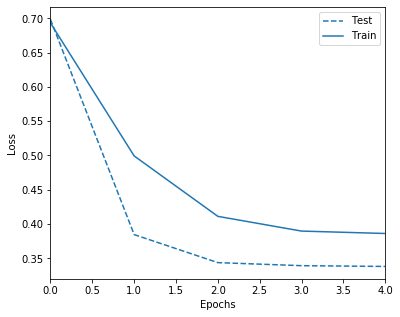

In [17]:
model_up.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.Recall()])

history = model_up.fit(up_X,
          pd.get_dummies(up_y),
          epochs=5,
          validation_data=(X_test, pd.get_dummies(y_test))
         )
plot_loss(history)
test_loss, test_acc = model_up.evaluate(X_test, pd.get_dummies(y_test))
print('Test accuracy:', test_acc)

In [18]:
print('전체채팅수{}, 유해채팅수{}'.format(len(X_test),model_up.predict_classes(X_test).sum()))

전체채팅수10500, 유해채팅수328


### Recall

In [19]:
from sklearn.metrics import recall_score, accuracy_score, f1_score

In [20]:
recall_score(y_test, model_up.predict_classes(X_test)),\
accuracy_score(y_test, model_up.predict_classes(X_test)),\
f1_score(y_test, model_up.predict_classes(X_test))

(0.29191321499013806, 0.9486666666666667, 0.3544910179640719)

In [ ]:
# model_up.save('../model/cnn_oversample.h5')

## Downsampling

In [48]:
down_X, down_y = RandomUnderSampler().fit_resample(X_train, y_train)

# 총 데이터 수 , 1 레이블 데이터 수
len(down_y), down_y.sum()

(3118, 1559)

In [49]:
model_down = keras.Sequential([
    keras.layers.Embedding(30000, 10),
    keras.layers.Conv1D(64, 3, padding="same", activation=tf.nn.relu,),
    keras.layers.Dropout(0.5),
    keras.layers.Conv1D(32, 3, padding="same", activation=tf.nn.relu),
    keras.layers.Dropout(0.5),
    keras.layers.Conv1D(32, 3, padding="same", activation=tf.nn.relu),
    keras.layers.Dropout(0.5),
    keras.layers.Conv1D(32, 3, padding="same", activation=tf.nn.relu),
    keras.layers.Dropout(0.5),
    keras.layers.Conv1D(32, 3, padding="same", activation=tf.nn.relu),
    keras.layers.Dropout(0.5),
    keras.layers.Conv1D(32, 3, padding="same", activation=tf.nn.relu),
    keras.layers.GlobalMaxPool1D(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2, activation=tf.nn.sigmoid)
])

Train on 3118 samples, validate on 10500 samples
Epoch 1/5
3118/3118 [==============================] - ETA: 2:55 - loss: 0.0586 - recall_1: 1.00 - ETA: 1:29 - loss: 0.0580 - recall_1: 1.00 - ETA: 45s - loss: 0.1209 - recall_1: 0.9766 - ETA: 25s - loss: 0.1338 - recall_1: 0.968 - ETA: 20s - loss: 0.1732 - recall_1: 0.954 - ETA: 15s - loss: 0.1841 - recall_1: 0.947 - ETA: 11s - loss: 0.1717 - recall_1: 0.950 - ETA: 10s - loss: 0.1586 - recall_1: 0.955 - ETA: 9s - loss: 0.1631 - recall_1: 0.957 - ETA: 7s - loss: 0.1783 - recall_1: 0.95 - ETA: 6s - loss: 0.1866 - recall_1: 0.94 - ETA: 6s - loss: 0.1909 - recall_1: 0.94 - ETA: 5s - loss: 0.1882 - recall_1: 0.94 - ETA: 4s - loss: 0.1934 - recall_1: 0.94 - ETA: 4s - loss: 0.1923 - recall_1: 0.94 - ETA: 4s - loss: 0.1891 - recall_1: 0.94 - ETA: 3s - loss: 0.1863 - recall_1: 0.94 - ETA: 3s - loss: 0.1899 - recall_1: 0.94 - ETA: 3s - loss: 0.1938 - recall_1: 0.94 - ETA: 2s - loss: 0.1954 - recall_1: 0.94 - ETA: 2s - loss: 0.1978 - recall_1: 0.9

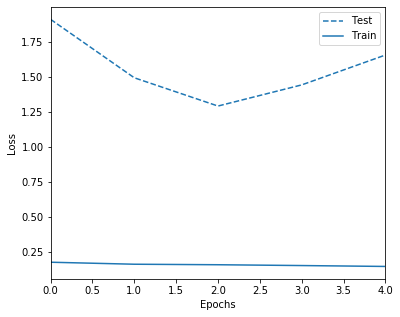

In [54]:
model_down.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.Recall()])

history = model_down.fit(down_X,
          pd.get_dummies(down_y),
          epochs=5,
          validation_data=(X_test, pd.get_dummies(y_test))
         )
plot_loss(history)
test_loss, test_acc = model_down.evaluate(X_test, pd.get_dummies(y_test))
print('Test Recall:', test_acc)

In [55]:
#recall
recall_score(y_test, model_down.predict_classes(X_test)), \
accuracy_score(y_test, model_down.predict_classes(X_test)),\
f1_score(y_test, model_down.predict_classes(X_test))

(0.633147113594041, 0.8083809523809524, 0.25260029717682014)

In [56]:
print('전체채팅수{}, 유해채팅수{}'.format(len(X_test),model_down.predict_classes(X_test).sum()))

전체채팅수10500, 유해채팅수2155


## 모델 체크포인트 저장

In [115]:
model_down.save('../model/cnn_undersample.h5')

# TODO
- 형태소별 Tokenize 말고 한글 자모별 Tokenize 하여 실험해보기
- CNN layer / Parameter 변경시켜보기
- 예측 결과 검정하기
    - Attention 이용